In [2]:
import os
os.environ['DJANGO_SETTINGS_MODULE'] = 'ClusterCast.settings'
import test_utils
import django
django.setup()
import sys
sys.path.append("/home/ajp031/StockDeepLearning/ClusterCast/ClusterCast")
from asgiref.sync import sync_to_async
from importlib import reload
import ClusterPipeline.models.ClusterProcessing as cp
from copy import deepcopy
import numpy as np
from tensorflow.keras.backend import clear_session

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7ff1c4b31e10>
Traceback (most recent call last):
  File "/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
2024-02-29 06:44:51.581570: I tensorflow/core/pl

In [3]:
reload(test_utils)

<module 'test_utils' from '/home/ajp031/ClusterCast/test_utils.py'>

In [4]:
group_ids = [29]
groups = await test_utils.extract_cluster_groups(group_ids)

Creating and Processing Dataset
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Empty DataFrame
Columns: []
Index: [2007-01-03 00:00:00]
                macd  macd_signal  macd_diff
Date                                        
2007-01-03 -0.074251     0.026503  -0.061887
Empty DataFrame
Columns: []
Index: [2007-01-03 00:00:00]
              stoch_k    stoch_d
Date                            
2007-01-03  19.435424  13.336049
first date stoch: 2007-01-03 00:00:00
last date stoch: 2024-02-26 00:00:00
first date df: 2007-01-03 00:00:00
last date df: 2024-02-26 00:00:00
['open', 'high', 'low', 'close', 'volume', 'Vix', 'sma5', 'sma10', 'sma20', 'sma30', 'sma50', 'sma100', 'sma200', 'ema5', 'ema10', 'ema20', 'ema30', 'ema50', 'ema100', 'ema200', 'bb_high10', 'bb_low10', 'bb_high20', 'bb_low20', 'bb_high40', 'bb_low40', 'bb_high60', 'bb_low60', 'smaVol5', 'smaVol10', 'smaVol20', 'smaVol50', 'rsi5', 'rsi1

In [5]:
clusters = await test_utils.get_all_clusters(groups)

In [6]:
cluster_of_interest_id = 296
cluster_of_interest = [cluster for cluster in clusters if cluster.id == cluster_of_interest_id][0]

In [7]:
features = groups[0].group_params.training_features

features

['pctChgopen',
 'pctChghigh',
 'pctChglow',
 'pctChgclose',
 'pctChgvolume',
 'pctChgVix',
 'pctDiff+sma5_close',
 'pctDiff+sma5_sma10',
 'pctDiff+sma5_sma20',
 'pctDiff+sma5_sma30',
 'pctDiff+sma5_sma50',
 'pctDiff+sma5_sma100',
 'pctDiff+sma5_sma200',
 'pctDiff+sma10_sma20',
 'pctDiff+sma10_sma30',
 'pctDiff+sma10_sma50',
 'pctDiff+sma10_sma100',
 'pctDiff+sma10_sma200',
 'pctDiff+sma20_sma30',
 'pctDiff+sma20_sma50',
 'pctDiff+sma20_sma100',
 'pctDiff+sma20_sma200',
 'pctDiff+sma30_sma50',
 'pctDiff+sma30_sma100',
 'pctDiff+sma30_sma200',
 'pctDiff+sma50_sma100',
 'pctDiff+sma50_sma200',
 'pctDiff+sma100_sma200',
 'pctDiff+sma10_close',
 'pctDiff+sma20_close',
 'pctDiff+sma30_close',
 'pctDiff+sma50_close',
 'pctDiff+sma100_close',
 'pctDiff+sma200_close',
 'pctDiff+ema5_close',
 'pctDiff+ema10_close',
 'pctDiff+ema20_close',
 'pctDiff+ema30_close',
 'pctDiff+ema50_close',
 'pctDiff+ema100_close',
 'pctDiff+ema200_close',
 'pctDiff+ema5_ema10',
 'pctDiff+ema5_ema20',
 'pctDiff+ema5_

In [8]:
cur_group = groups[0]

In [9]:
# cur_group = await test_utils.recreate_group(cur_group)

In [10]:

X_train, y_train, X_test, y_test = cur_group.get_3d_array() 
cluster_features = cur_group.group_params.cluster_features
X_feature_dict = cur_group.group_params.X_feature_dict
y_feature_dict = cur_group.group_params.y_feature_dict
training_dict = {}
training_dict['0'] = (0,(X_train, y_train, X_test, y_test))
print(training_dict['0'][1][0].shape)
print(training_dict['0'][1][1].shape)
print(training_dict['0'][1][2].shape)
print(training_dict['0'][1][3].shape)

(6866, 20, 517)
(6866, 36)
(1672, 20, 517)
(1672, 36)


In [11]:
print(len(X_feature_dict))
print(len(cur_group.group_params.X_cols))

517
517


In [12]:
print(X_feature_dict)

{'Vix': 0, 'bb_high10': 1, 'bb_high20': 2, 'bb_high40': 3, 'bb_high60': 4, 'bb_indicator10': 5, 'bb_indicator10-3': 6, 'bb_indicator10-6': 7, 'bb_indicator20': 8, 'bb_indicator20-3': 9, 'bb_indicator20-6': 10, 'bb_indicator40': 11, 'bb_indicator40-3': 12, 'bb_indicator40-6': 13, 'bb_indicator60': 14, 'bb_indicator60-3': 15, 'bb_indicator60-6': 16, 'bb_low10': 17, 'bb_low20': 18, 'bb_low40': 19, 'bb_low60': 20, 'close': 21, 'deriv+ema10': 22, 'deriv+ema10-3': 23, 'deriv+ema10-6': 24, 'deriv+ema100': 25, 'deriv+ema100-3': 26, 'deriv+ema100-6': 27, 'deriv+ema20': 28, 'deriv+ema20-3': 29, 'deriv+ema20-6': 30, 'deriv+ema200': 31, 'deriv+ema200-3': 32, 'deriv+ema200-6': 33, 'deriv+ema30': 34, 'deriv+ema30-3': 35, 'deriv+ema30-6': 36, 'deriv+ema5': 37, 'deriv+ema5-3': 38, 'deriv+ema5-6': 39, 'deriv+ema50': 40, 'deriv+ema50-3': 41, 'deriv+ema50-6': 42, 'deriv+sma10': 43, 'deriv+sma10-3': 44, 'deriv+sma10-6': 45, 'deriv+sma100': 46, 'deriv+sma100-3': 47, 'deriv+sma100-6': 48, 'deriv+sma20': 49,

In [13]:
next_clusters = test_utils.cluster_a_group(cur_group,training_dict['0'][1],4)
next_label = 0
training_dict['1'] = next_clusters[next_label]

(20, 2)


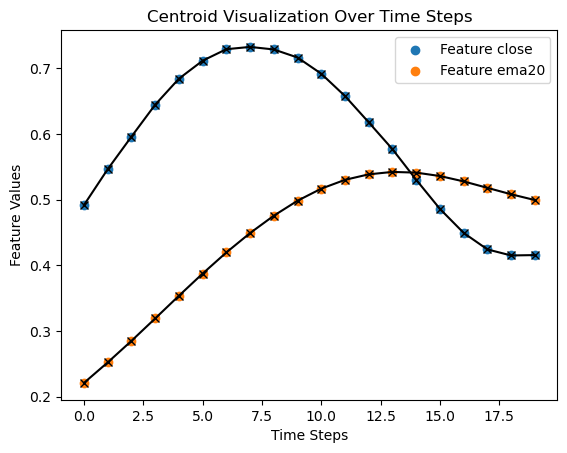

(20, 2)


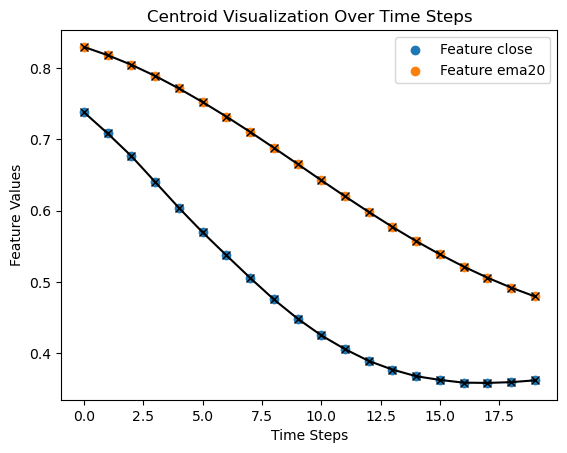

(20, 2)


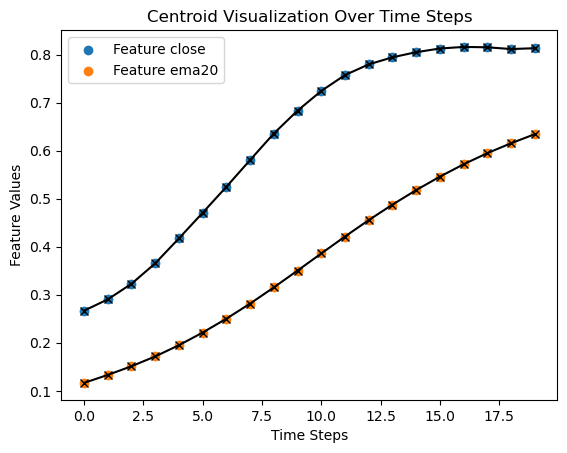

(20, 2)


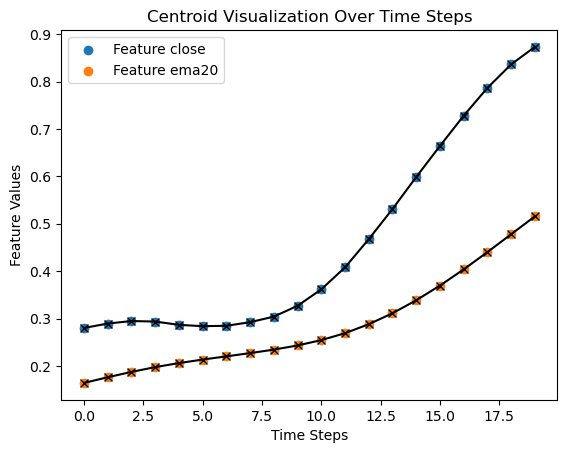

In [14]:
for i in range(len(next_clusters)): 
    print(next_clusters[i][0].shape)
    plot = test_utils.visualize_cluster_centroid(next_clusters[i][0],cluster_features)
    plot.show()

(20, 2)


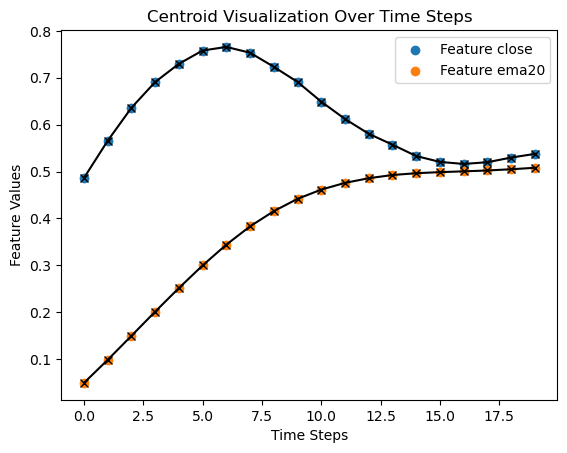

(20, 2)


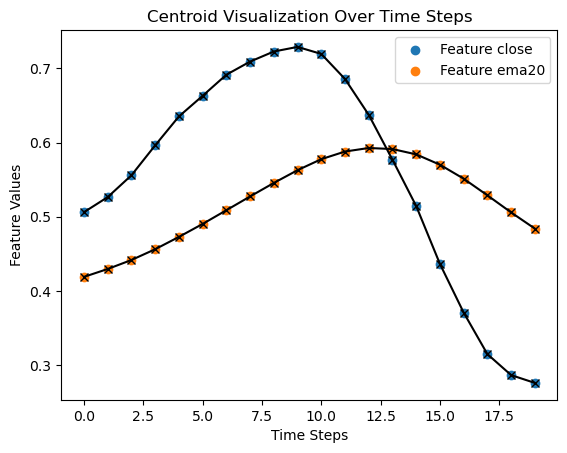

In [15]:
next_clusters = test_utils.cluster_a_group(cur_group,training_dict['1'][1],2)
for i in range(len(next_clusters)): 
    print(next_clusters[i][0].shape)
    plot = test_utils.visualize_cluster_centroid(next_clusters[i][0],cluster_features)
    plot.show()
next_label = 0
training_dict['2'] = next_clusters[next_label]

(20, 2)


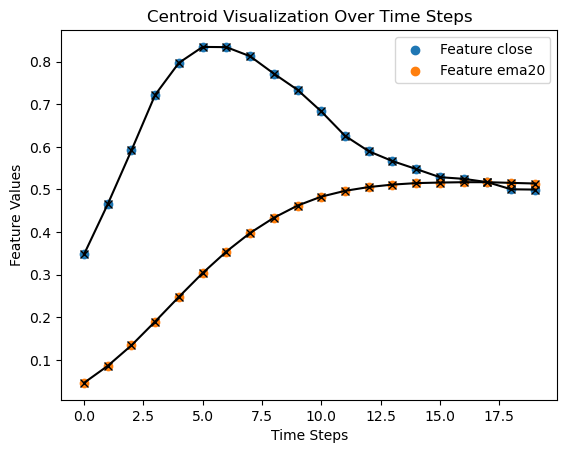

(20, 2)


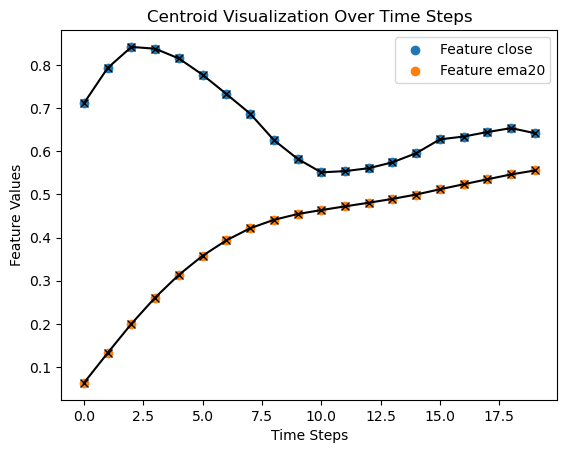

(20, 2)


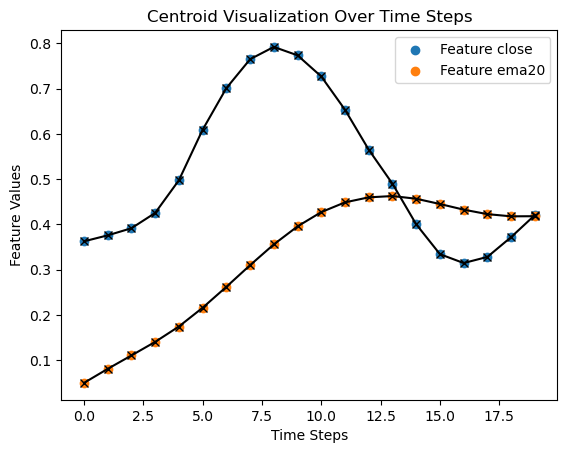

In [16]:
next_clusters = test_utils.cluster_a_group(cur_group,training_dict['2'][1],3)
for i in range(len(next_clusters)): 
    print(next_clusters[i][0].shape)
    plot = test_utils.visualize_cluster_centroid(next_clusters[i][0],cluster_features)
    plot.show()
next_label = 0
training_dict['3'] = (next_clusters[next_label])

In [17]:
import random
target_features = [] 
# target_features += ['pctChgclose{}_target'.format(i) for i in range(-14, 0) ]
# target_features += ['pctChgclose-0_target']
target_features += ['pctChgclose+{}_target'.format(i) for i in range(1, 7) ]
training_features = random.sample(features, 30)
print(training_features)

['bb_indicator60', 'rsi50', 'pctDiff+sma30_sma50', 'pctChgClHi', 'pctDiff+ema30_close', 'pctDiff+bb_high_close20', 'deriv+sma100', 'pctDiff+ema30_ema50', 'pctDiff+ema5_ema200', 'pctDiff+sma5_sma10', 'pctDiff+ema10_close', 'pctDiff+sma5_sma30', 'pctDiff+bb_low_close20', 'deriv+smaVol5', 'pctDiff+sma5_close', 'bb_indicator40', 'pctDiff+sma50_sma100', 'pctDiff+ema20_ema50', 'pctDiff+bb_low_close60', 'pctDiff+bb_high_close60', 'deriv+sma20', 'pctDiff+sma100_sma200', 'rsi20', 'deriv+ema50', 'pctDiff+ema10_ema30', 'rsi5', 'pctChgvolume', 'pctDiff+sma10_sma20', 'pctDiff+ema30_ema100', 'deriv+ema30']


In [18]:
reload(test_utils)

<module 'test_utils' from '/home/ajp031/ClusterCast/test_utils.py'>

In [19]:
print(target_features)
print(len(target_features))

['pctChgclose+1_target', 'pctChgclose+2_target', 'pctChgclose+3_target', 'pctChgclose+4_target', 'pctChgclose+5_target', 'pctChgclose+6_target']
6


In [20]:
centroid =  training_dict['1'][0]
X_train, y_train, X_test, y_test = training_dict['1'][1]

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_feature_dict)

(1127, 20, 517)
(1127, 36)
(280, 20, 517)
(280, 36)
{'pctChgclose+1_target': 0, 'pctChgclose+2_target': 1, 'pctChgclose+3_target': 2, 'pctChgclose+4_target': 3, 'pctChgclose+5_target': 4, 'pctChgclose+6_target': 5, 'pctChgclose-0_target': 6, 'pctChgclose-10_target': 7, 'pctChgclose-11_target': 8, 'pctChgclose-12_target': 9, 'pctChgclose-13_target': 10, 'pctChgclose-14_target': 11, 'pctChgclose-1_target': 12, 'pctChgclose-2_target': 13, 'pctChgclose-3_target': 14, 'pctChgclose-4_target': 15, 'pctChgclose-5_target': 16, 'pctChgclose-6_target': 17, 'pctChgclose-7_target': 18, 'pctChgclose-8_target': 19, 'pctChgclose-9_target': 20, 'sumPctChgclose+1': 21, 'sumPctChgclose+10': 22, 'sumPctChgclose+11': 23, 'sumPctChgclose+12': 24, 'sumPctChgclose+13': 25, 'sumPctChgclose+14': 26, 'sumPctChgclose+15': 27, 'sumPctChgclose+2': 28, 'sumPctChgclose+3': 29, 'sumPctChgclose+4': 30, 'sumPctChgclose+5': 31, 'sumPctChgclose+6': 32, 'sumPctChgclose+7': 33, 'sumPctChgclose+8': 34, 'sumPctChgclose+9': 35

In [21]:
# cur_group.run_clustering()
# all_centroids = cur_group.cluster_centers

# closted_centroid_label = test_utils.find_closest_centroid(centroid,all_centroids)
# print(closted_centroid_label)



In [22]:
# print(cur_group.cluster_centers.shape)   


In [23]:
# print(closted_centroid_label)
# test_utils.visualize_cluster_centroid(centroid,cluster_features).show()
# test_utils.visualize_cluster_centroid(all_centroids[closted_centroid_label],cluster_features).show()


In [24]:
print(len(cur_group.clusters))

16


In [25]:

X_train_filtered = test_utils.filter_by_features(X_train, training_features, X_feature_dict)
X_test_filtered = test_utils.filter_by_features(X_test, training_features, X_feature_dict)
y_train_filtered = test_utils.filter_y_by_features(y_train, target_features, y_feature_dict)
y_test_filtered = test_utils.filter_y_by_features(y_test, target_features, y_feature_dict)
print(X_train_filtered.shape)
print(y_train_filtered.shape)
print(X_test_filtered.shape)
print(y_test_filtered.shape)

[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
(1127, 20, 30)
(1127, 6)
(280, 20, 30)
(280, 6)


In [26]:
attention_model = test_utils.create_attention_model(input_steps=X_train.shape[1],output_steps=len(target_features),features=len(training_features))


2024-02-29 06:47:51.852319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-29 06:47:51.886901: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-29 06:47:51.888672: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [27]:
trainined_attention_model = test_utils.train_model(attention_model, (X_train, y_train, X_test, y_test), training_features, 
                                                   target_features, X_feature_dict, y_feature_dict,
                                                   epochs = 100, batch_size = 32, lr = 0.0001, early_stopping_patience = 15,
                                                   loss = 'mse')

[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]
Epoch 1/100


2024-02-29 06:47:53.666182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-29 06:47:53.667555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-29 06:47:53.668455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

33/36 [==========================>...] - ETA: 0s - loss: 2.7814

2024-02-29 06:48:02.975791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-02-29 06:48:02.977274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-02-29 06:48:02.978403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

36/36 [==============================] - 11s 52ms/step - loss: 2.7695 - val_loss: 2.6293
Epoch 2/100
36/36 [==============================] - 1s 20ms/step - loss: 2.4236 - val_loss: 2.3125
Epoch 3/100
36/36 [==============================] - 1s 20ms/step - loss: 2.1307 - val_loss: 2.0443
Epoch 4/100
36/36 [==============================] - 1s 20ms/step - loss: 1.8813 - val_loss: 1.8152
Epoch 5/100
36/36 [==============================] - 1s 20ms/step - loss: 1.6685 - val_loss: 1.6198
Epoch 6/100
36/36 [==============================] - 1s 20ms/step - loss: 1.4860 - val_loss: 1.4526
Epoch 7/100
36/36 [==============================] - 1s 20ms/step - loss: 1.3293 - val_loss: 1.3068
Epoch 8/100
36/36 [==============================] - 1s 20ms/step - loss: 1.1944 - val_loss: 1.1830
Epoch 9/100
36/36 [==============================] - 1s 20ms/step - loss: 1.0791 - val_loss: 1.0755
Epoch 10/100
36/36 [==============================] - 1s 20ms/step - loss: 0.9787 - val_loss: 0.9841
Epoch 11/1

KeyboardInterrupt: 

: 

In [ ]:
attention_model_accuracy, attention_results = test_utils.eval_model(X_test_filtered, y_test_filtered, trainined_attention_model)

In [ ]:
reload(test_utils)

In [ ]:
print(attention_model_accuracy)
test_utils.visualize_future_distribution(attention_results)

In [ ]:
centroid =  training_dict['2'][0]
X_train_smaller, y_train_smaller, X_test_smaller, y_test_smaller= training_dict['2'][1]
# X_train_larger = np.concatenate((X_train, X_train_larger), axis=0)
# y_train_larger = np.concatenate((y_train, y_train_larger), axis=0)
# X_test_larger = np.concatenate((X_test, X_test_larger), axis=0)
# y_test_larger = np.concatenate((y_test, y_test_larger), axis=0)

# X_train_larger = np.concatenate((X_train, X_train_larger), axis=0)
# y_train_larger = np.concatenate((y_train, y_train_larger), axis=0)
# X_test_larger = np.concatenate((X_test, X_test_larger), axis=0)
# y_test_larger = np.concatenate((y_test, y_test_larger), axis=0)

X_train_smaller_filtered = test_utils.filter_by_features(X_train_smaller, training_features, X_feature_dict)
X_test_smaller_filtered = test_utils.filter_by_features(X_test_smaller, training_features, X_feature_dict)
y_train_smaller_filtered = test_utils.filter_y_by_features(y_train_smaller, target_features, y_feature_dict)
y_test_smaller_filtered = test_utils.filter_y_by_features(y_test_smaller, target_features, y_feature_dict)



print(X_train_smaller_filtered.shape)
print(y_train_smaller_filtered.shape)
print(X_test_smaller_filtered.shape)
print(y_test_smaller_filtered.shape)

In [ ]:
larger_train_model = test_utils.train_model(deepcopy(trainined_attention_model), (X_train_smaller, y_train_smaller, X_test_smaller, y_test_smaller), training_features, 
                                                   target_features, X_feature_dict, y_feature_dict,
                                                   epochs = 150, batch_size = 32, lr = 0.0001, early_stopping_patience = 30,
                                                   loss = 'mse')

In [ ]:
large_data_set_accuracy, large_data_set_results = test_utils.eval_model(X_test_smaller_filtered, y_test_smaller_filtered, larger_train_model)

In [ ]:
benchmark_model = test_utils.create_attention_model(input_steps=X_train.shape[1],output_steps=len(target_features),features=len(training_features))
benchark_model = test_utils.train_model(benchmark_model, (X_train_smaller, y_train_smaller, X_test_smaller, y_test_smaller), training_features,
                                        target_features, X_feature_dict, y_feature_dict,
                                        epochs = 250, batch_size = 32, lr = 0.001, early_stopping_patience = 30,
                                        loss = 'mse')

In [ ]:
# benchark_model = test_utils.train_model(benchmark_model, (X_train_smaller, y_train_smaller, X_test_smaller, y_test_smaller), training_features,
#                                         target_features, X_feature_dict, y_feature_dict,
#                                         epochs = 250, batch_size = 16, lr = 0.0001, early_stopping_patience = 30,
#                                         loss = test_utils.custom_profit_loss_percent_change)

In [ ]:
bench_model_accuracy, bench_results = test_utils.eval_model(X_test_smaller_filtered, y_test_smaller_filtered, benchmark_model)

In [ ]:
print("FINE TUNED MODEL")
print(large_data_set_accuracy)
test_utils.visualize_future_distribution(large_data_set_results)

In [ ]:
print("BENCHMARK MODEL")
print(bench_model_accuracy)
test_utils.visualize_future_distribution(bench_results)

In [ ]:
aligned_columns = ['predicted_1', 'real_1', 'predicted_2', 'real_2', 'predicted_3', 'real_3', 'predicted_4', 'real_4', 'predicted_5', 'real_5', 'predicted_6', 'real_6']
bench_results[aligned_columns].head(30)

In [ ]:
clear_session()